# Final

기존의 시계열 속도 데이터만 이용한 예측 모델에
시간정보를 도입하여 봅시다.

feature를 변경하거나 DNN의 hyperparameter 등을 변경하며
예측 정확도를 개선해봅시다.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
#   set LABEL first
output_cols = ['vel']
path = '/content/drive/My Drive/dnn_tutorial/'

일부 input column 들을 제거하거나, 

numerical column을 categorical column으로 변경해보며 

최적 모델을 찾아봅시다.

In [0]:
#   set input column - historical speed data + time data
# removed from input columns -  'time', 'date'
input_cols_num_raw = ['vel_t05', 'vel_t10', 'vel_t15', 'vel_t20',
               'vel_t25', 'vel_t30', 'vel_t35',  'vel_t40' ]

input_cols_num_norm = ['time_sin', 'time_cos', 'date_sin','date_cos', 
                       'month_sin','month_cos', 'date_in_month_serial', 
                       ]
input_cols_num = input_cols_num_norm+ input_cols_num_raw

input_cols_cat = ['day', 'isholiday']
input_cols= input_cols_num + input_cols_cat

In [0]:
train_data = pd.read_csv(path+'time_traffic_data_train.csv', index_col = 0)

#categorical column 은 str 형으로 저장이 되도록 합니다.
train_data[input_cols_cat] = train_data[input_cols_cat].astype('str')

#원하는 경우 다른 이상치 제거 방법을 적용해보십시오.
vel_upper_limit = train_data['vel'].quantile(q=0.98)
train_data = train_data[train_data['vel']<=vel_upper_limit]

# linear scaling을 사용하지 않고 훈련하였을 때의 결과도 확인해 봅시다.
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
scaler.fit(train_data['vel'].values.reshape(-1,1))

def normalize_numeric(dataframe, input_col_list, output_col_list):
    return_df = dataframe.copy()
    for col in input_col_list:
        return_df.loc[:, col] = pd.DataFrame(
            scaler.transform(return_df[col].values.reshape(-1, 1)),
            columns=[col], index=return_df.index)
    for col in output_col_list:
        col_backup = 'backup_'+col
        return_df[col_backup] = return_df[col].copy()
    for col in output_col_list:
        return_df.loc[:, col] = pd.DataFrame(
            scaler.transform(return_df[col].values.reshape(-1, 1)),
            columns=[col], index=return_df.index)
    return return_df

#input_cols_num_raw 에 해당되는 column 만 normalize 해줘야합니다.
train_data = normalize_numeric(train_data, input_cols_num_raw, output_cols)


In [27]:
scaler.data_min_, scaler.data_max_

(array([7.3654776]), array([99.803825]))

In [28]:
train_data

,time_sin,time_cos,date_sin,date_cos,month_sin,month_cos,date_in_month_serial,time,date,day,isholiday,datetime,dateindex,V_ID,vel,vel_t05,vel_t10,vel_t15,vel_t20,vel_t25,vel_t30,vel_t35,vel_t40,backup_vel
93150,0.943505,0.730874,0.260633,0.938980,0.500000,1.000000,0.064516,405,20151202,2,0.0,20151202 405,96529,0010VS00030,0.841345,0.823235,0.857345,0.837789,0.798058,0.826011,0.815343,0.852181,0.818026,85.138050
75315,0.019975,0.360086,0.001041,0.467746,0.000000,0.500000,0.900000,1650,20150927,6,1.0,20150927 1650,77674,0010VS00030,0.195900,0.160930,0.155088,0.153219,0.252853,0.144987,0.195179,0.174999,0.088836,25.474176
12234,0.973465,0.660720,0.843526,0.863304,0.933013,0.750000,0.464286,440,20150213,4,0.0,20150213 440,12440,0010VS00030,0.816647,0.792942,0.799849,0.820610,0.863718,0.826748,0.804296,0.842419,0.827580,82.854935
10129,0.000000,0.500000,0.790400,0.907023,0.933013,0.750000,0.178571,1755,20150205,3,0.0,20150205 1755,10295,0010VS00030,0.921147,0.900029,0.914392,0.908267,0.890328,0.937109,0.913769,0.927074,0.932703,92.514790
33632,0.231350,0.078304,0.931571,0.247519,0.750000,0.066987,0.064516,1405,20150502,5,0.0,20150502 1405,35017,0010VS00030,0.581487,0.470734,0.557693,0.543191,0.559437,0.543247,0.473941,0.420210,0.387306,61.117207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23842,0.711309,0.953154,0.997959,0.545126,1.000000,0.500000,0.870968,135,20150327,4,0.0,20150327 135,24499,0010VS00030,0.884908,0.899287,0.917195,0.897239,0.914010,0.908773,0.897554,0.890144,0.950551,89.164880
59653,0.804381,0.896677,0.234635,0.076230,0.066987,0.250000,0.096774,225,20150803,0,0.0,20150803 225,61661,0010VS00030,0.972570,0.948330,0.933671,0.975451,0.958624,0.935571,0.976544,0.977857,1.000435,97.268210
67242,0.240613,0.927456,0.077375,0.232814,0.066987,0.250000,0.935484,2150,20150829,5,0.0,20150829 2150,69382,0010VS00030,0.951323,0.938844,0.953514,0.935219,0.953050,0.958382,0.937843,0.939930,0.951464,95.304190
68078,0.339280,0.973465,0.064147,0.254986,0.000000,0.500000,0.033333,2240,20150901,1,0.0,20150901 2240,70256,0010VS00030,0.849617,0.819426,0.839462,0.810799,0.813145,0.834363,0.893972,0.899827,0.879702,85.902664


이제 데이터프레임의 데이터를 Data API 에서 지원하는 dataset 형태로 
변환하는 함수 df_to_dataset 을 만듭니다.

함수에 batch_size에 원하는 값을 넣어주어
minibatch의 크기를 지정하게됩니다.


In [0]:
def df_to_dataset(dataframe, input_col_list, output_col_list, batch_size, training= True):

    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe[input_col_list]), dataframe[output_col_list].values ))
    if training:
      dataset = dataset.shuffle(buffer_size= len(dataframe))
    dataset = dataset.batch(batch_size= batch_size)
    return dataset

함수가 제대로 동작하는지 확인해봅시다.


In [30]:
train_dataset = df_to_dataset(train_data, input_cols, output_cols, 4)

example_batch = next(iter(train_dataset))

print(list(example_batch[0].keys()))
# print(example_batch[0]['day'])
print(example_batch[1] )

['time_sin', 'time_cos', 'date_sin', 'date_cos', 'month_sin', 'month_cos', 'date_in_month_serial', 'vel_t05', 'vel_t10', 'vel_t15', 'vel_t20', 'vel_t25', 'vel_t30', 'vel_t35', 'vel_t40', 'day', 'isholiday']
tf.Tensor(
[[0.1161864 ]
 [0.93474607]
 [0.94982568]
 [0.85309381]], shape=(4, 1), dtype=float64)


출력 결과의 첫번째 줄은 input의 column을 의미합니다.
두번째 줄은 categorical column 인 'V_ID' 의 값을 보여줍니다.
세번째 줄은 label을 보여줍니다.

feature_column 은 모두  feature_columns 리스트에 저장하도록 합니다.

숫자형 데이터는 numeric_column 으로 변환할 수 있습니다.

In [0]:
feature_columns = []
for col in input_cols_num:
    feature_columns.append(feature_column.numeric_column(col))


Categorical column 은 두가지 과정을 거쳐야 DNN이 인식할 수 있습니다.

먼저 categorical_column_with_vocabulary_list 를 통해 category를 저장합니다.


In [0]:
for col in input_cols_cat:
  temp_cat_column = feature_column.categorical_column_with_vocabulary_list(col, sorted(train_data[col].unique().tolist()))
  feature_columns.append(feature_column.indicator_column(temp_cat_column))

feature_column 을 통해 변환된 값을 출력하는 함수 demo를 작성하고 그 결과를 확인해봅시다.


In [38]:
def demo(feature_column_list):
  feature_layer = keras.layers.DenseFeatures(feature_column_list)
  print(feature_layer(example_batch[0]).numpy())
for i in feature_columns:
  print(i)
demo(feature_columns)


NumericColumn(key='time_sin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='time_cos', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='date_sin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='date_cos', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='month_sin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='month_cos', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='date_in_month_serial', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='vel_t05', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='vel_t10', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
NumericColumn(key='vel_t15', shape=(1,), default_value=None, dtype=tf.float32, normalize

이제 batch_size를 큰 값으로 늘린뒤에 DNN을 컴파일해봅시다.


In [0]:
train_dataset = df_to_dataset(train_data, input_cols, output_cols, 1024)

model = keras.Sequential()
model.add(keras.layers.DenseFeatures(feature_columns))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(1, activation=None))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])


In [40]:
model.fit(train_dataset, epochs= 10)
model.summary()


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

82/82 [==============================] - 1s 14ms/step - loss: 0.0589 - mae: 0.1532
Epoch 2/10
82/82 [==============================] - 1s 14ms/step - loss: 0.0033 - mae: 0.0356
Epoch 3/10
82/82 [==============================] - 1s 15ms/step - loss: 0.0022 - mae: 0.0271
Epoch 4/10
82/82 [==============================] - 1s 15ms/step - loss: 0.0017 - mae: 0.0244
Epoch 5/10
82/82 [==============================] - 1s 15ms/step - loss: 0.0015 - mae: 0.0227
Epoch 6/10
82/82 [====================

마찬가지로 퍼센트 에러의 계산과 test data 에 대한 evaluation 결과를 확인하겠습니다.


In [41]:
train_predict= model.predict(train_dataset)

train_predict =pd.DataFrame(scaler.inverse_transform(train_predict), index= train_data.index, columns=['prediction'])
percentage_error = (train_predict['prediction'] - train_data['backup_vel']).abs()/ train_data['backup_vel']*100
percentage_error

93150      8.860324
75315    278.097889
12234     12.385163
10129      2.352863
33632     41.854228
            ...    
23842      3.544299
59653      0.165503
67242     16.241457
68078      5.579748
75470     72.096893
Length: 83467, dtype: float64

In [42]:
percentage_error.mean()

9.651284645766856

In [46]:
test_data = pd.read_csv(path+'time_traffic_data_test.csv', index_col = 0)

#categorical column 은 str 형으로 저장이 되도록 합니다.
test_data[input_cols_cat] = test_data[input_cols_cat].astype('str')
test_data = normalize_numeric(test_data, input_cols_num_raw, output_cols)

test_dataset = df_to_dataset(test_data, input_cols, output_cols, 1024,training=False)

model.evaluate(test_dataset)


16/16 [==============================] - 0s 13ms/step - loss: 0.0011 - mae: 0.0204


[0.0011256929719820619, 0.020441023632884026]

In [0]:
test2_data = pd.read_csv(path+'time_traffic_data_test2.csv', index_col = 0)
test2_data['date'] = pd.to_datetime(test2_data['date'], format='%Y%m%d')
test2_data['time'] = test2_data['time'].map(
                        lambda x: pd.Timedelta(hours=x // 100, minutes=x % 100))
test2_data['datetime'] = test2_data['date'] + test2_data['time']

#categorical column 은 str 형으로 저장이 되도록 합니다.
test2_data[input_cols_cat] = test2_data[input_cols_cat].astype('str')
test2_data = normalize_numeric(test2_data, input_cols_num_raw, output_cols)

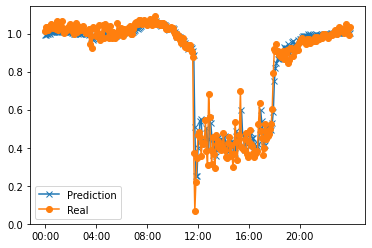

In [52]:
test2_dataset = df_to_dataset(test2_data, input_cols, output_cols, 1024,training=False)
prediction = model.predict(test2_dataset)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

# im = ax.plot(scaler.inverse_transform(prediction),'-x',test2_data['backup_vel'], '-o')
im = ax.plot(prediction,'-x',test2_data['vel'], '-o')
ax.set_ylim(bottom=0)
xtick_list = [x for x in range(
        0, len(prediction), len(prediction) // 6)]
ax.set_xticks(xtick_list)
ax.set_xticklabels([test2_data['datetime'][x].strftime('%H:%M') for x in xtick_list])
ax.legend(['Prediction', 'Real'])